In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import joblib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from tqdm.auto import tqdm
from calcium_imaging_analysis.analysis import proc_photobleach, proc_photoswitch
from calcium_imaging_analysis.io import nonlibrary_name

## User functions

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit


def monoexp_decay(t, I0, tau, C=0):
    """
    Monoexponential decay function
    I(t) = I0 * exp(-t/tau) + C
    """
    return I0 * np.exp(-t / tau) + C


def fit_single_curve(time, intensity, include_offset=False):
    """
    Fit a single photobleaching curve to monoexponential decay

    Returns:
    dict with fit parameters and R²
    """

    if include_offset:
        fit_func = monoexp_decay
        p0 = [intensity.iloc[0], time.mean(), intensity.min()]
        param_names = ["I0", "tau", "C"]
    else:
        fit_func = lambda t, I0, tau: monoexp_decay(t, I0, tau, C=0)
        p0 = [intensity.iloc[0], time.mean()]
        param_names = ["I0", "tau"]

    try:
        popt, pcov = curve_fit(fit_func, time, intensity, p0=p0, maxfev=2000)
        fitted = fit_func(time, *popt)

        # Calculate R²
        ss_res = np.sum((intensity - fitted) ** 2)
        ss_tot = np.sum((intensity - intensity.mean()) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        # Parameter errors
        param_errors = np.sqrt(np.diag(pcov))

        results = {"r_squared": r_squared, "success": True}

        # Add parameters
        for name, value, error in zip(param_names, popt, param_errors):
            results[name] = value
            results[f"{name}_error"] = error

    except Exception as e:
        results = {"r_squared": None, "success": False, "error": str(e)}

        # Add None values for parameters
        for name in param_names:
            results[name] = None
            results[f"{name}_error"] = None

    return results


def analyze_photobleaching_data(
    df, biosensor_col="biosensor", cell_col="cell_id", time_col="time", intensity_col="intensity", include_offset=False
):
    """
    Analyze photobleaching data from long-form dataframe

    Parameters:
    df: pandas DataFrame with columns for biosensor, cell_id, time, intensity
    biosensor_col: name of biosensor column
    cell_col: name of cell ID column
    time_col: name of time column
    intensity_col: name of intensity column
    include_offset: whether to include background offset C in fit

    Returns:
    tuple: (individual_results_df, summary_stats_df)
    """

    individual_results = []

    # Group by biosensor and cell
    for (biosensor, cell_id), group in tqdm(df.groupby([biosensor_col, cell_col])):
        # Sort by time to ensure proper order
        group = group.sort_values(time_col)

        time = group[time_col].values
        intensity = group[intensity_col].values

        # Fit the curve
        fit_result = fit_single_curve(pd.Series(time), pd.Series(intensity), include_offset)

        # Store results
        row = {"biosensor": biosensor, "cell_id": cell_id, "n_timepoints": len(time), **fit_result}

        individual_results.append(row)

    individual_df = pd.DataFrame(individual_results)

    # Calculate summary statistics per biosensor
    summary_stats = []

    for biosensor in individual_df["biosensor"].unique():
        biosensor_data = individual_df[individual_df["biosensor"] == biosensor]
        successful_fits = biosensor_data[biosensor_data["success"] == True]

        if len(successful_fits) > 0:
            r2_values = successful_fits["r_squared"].dropna()
            tau_values = successful_fits["tau"].dropna()

            summary = {
                "biosensor": biosensor,
                "n_cells": len(biosensor_data),
                "n_successful_fits": len(successful_fits),
                "success_rate": len(successful_fits) / len(biosensor_data),
                # R² statistics
                "r2_mean": r2_values.mean(),
                "r2_std": r2_values.std(),
                "r2_median": r2_values.median(),
                "r2_min": r2_values.min(),
                "r2_max": r2_values.max(),
                # Tau statistics
                "tau_mean": tau_values.mean(),
                "tau_std": tau_values.std(),
                "tau_median": tau_values.median(),
                # Quality metrics
                "excellent_fits": (r2_values > 0.95).sum(),
                "good_fits": ((r2_values > 0.90) & (r2_values <= 0.95)).sum(),
                "poor_fits": (r2_values <= 0.90).sum(),
                "fraction_excellent": (r2_values > 0.95).mean(),
                "fraction_good_or_better": (r2_values > 0.90).mean(),
            }
        else:
            summary = {
                "biosensor": biosensor,
                "n_cells": len(biosensor_data),
                "n_successful_fits": 0,
                "success_rate": 0.0,
                "r2_mean": None,
                "r2_std": None,
                "r2_median": None,
                "r2_min": None,
                "r2_max": None,
                "tau_mean": None,
                "tau_std": None,
                "tau_median": None,
                "excellent_fits": 0,
                "good_fits": 0,
                "poor_fits": 0,
                "fraction_excellent": 0.0,
                "fraction_good_or_better": 0.0,
            }

        summary_stats.append(summary)

    summary_df = pd.DataFrame(summary_stats)

    return individual_df, summary_df

In [4]:
# setup_plotting_env()
fig_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-05 (ScarCaMP paper)"
os.makedirs(fig_dir, exist_ok=True)

# Photobleaching

In [5]:
df_save_fname = os.path.join("/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/red_calcium_screen/for_paper/invitro_results/photobleaching_df.parquet")
# os.makedirs(os.path.dirname(df_save_fname), exist_ok=True)

In [6]:
### WE ONLY NEED THIS CELL IF WE'RE REPEATING PRE-PROCESSING

# root_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/red_calcium_screen/"
# base_dir = os.path.join(root_dir, "hek_cell_imiaging_photobleaching/")

# output_fig_dir = os.path.join(base_dir, "_figs")
# os.makedirs(output_fig_dir, exist_ok=True)

# proc_data = sorted(glob.glob(os.path.join(base_dir, "**", "*.p"), recursive=True))
# proc_data = [os.path.normpath(_img) for _img in proc_data]

In [7]:
data_channel = ["TRITC"]
force = False

In [8]:
if not os.path.exists(df_save_fname) or force:
    delays = [
        joblib.delayed(proc_photobleach)(_proc, data_channel=data_channel, force=False, output_fig_dir=output_fig_dir)
        for _proc in proc_data
    ]
    print(len(delays))
    results = joblib.Parallel(n_jobs=6, verbose=20)(delays)
    photobleaching_traces_df = pd.concat(results)
    photobleaching_traces_df["t_ave"] = photobleaching_traces_df["frame_number"].map(
        photobleaching_traces_df.groupby("frame_number")["t"].mean().round(1)
    )
    photobleaching_traces_df.to_parquet(df_save_fname)
else:
    photobleaching_traces_df = pd.read_parquet(df_save_fname)

In [9]:
photobleaching_traces_df["date_string"] = photobleaching_traces_df["filename"].str.extract("([0-9]+\-[0-9]+\-[0-9]+)")
plt_df = (
    photobleaching_traces_df.groupby(["roi", "date_string", "well_sanitized", "well", "frame_number"])["value"]
    .mean()
    .reset_index()
)
plt_df["well_sanitized"] = plt_df["well"].apply(nonlibrary_name)

In [10]:
# test = joblib.load(proc_data[-2])

In [11]:
plt_df["well_sanitized"] = plt_df["well_sanitized"].replace("jm27", "jrgeco1a")
plt_df["well_sanitized"] = plt_df["well_sanitized"].replace("jm28", "jrcamp1b")
plt_df["well_sanitized"] = plt_df["well_sanitized"].replace("jm56", "scarcamp")

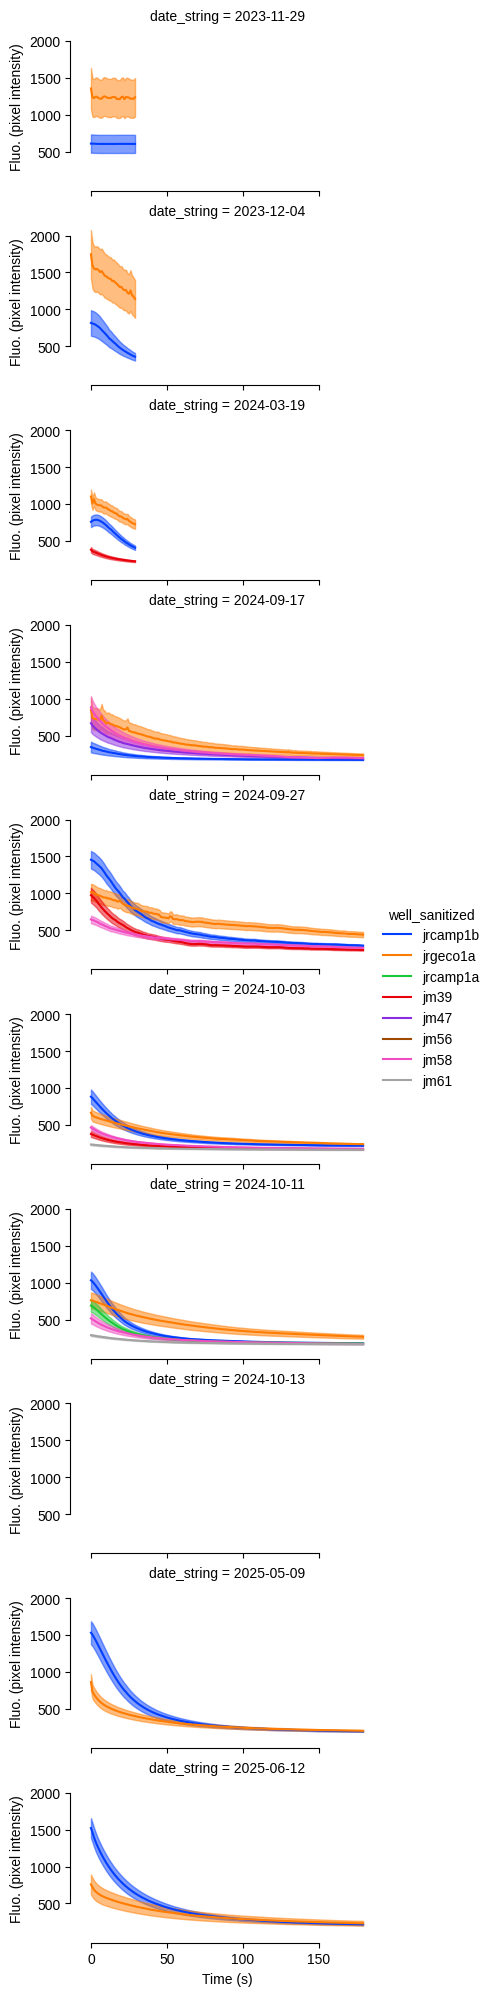

In [12]:
# fig, ax = plt.subplots(1, figsize=(3, 3))
g = sns.relplot(
    plt_df,
    kind="line",
    x="frame_number",
    y="value",
    row="date_string",
    hue="well_sanitized",
    hue_order=["jrcamp1b", "jrgeco1a", "jrcamp1a", "jm39", "jm47", "jm56", "jm58", "jm61"],
    height=2,
    aspect=2,
    palette="bright",
    errorbar=("se", 2),
    err_kws={"alpha": 0.5},
)
sns.despine(offset=5, trim=True)
g.set(ylabel="Fluo. (pixel intensity)", xlabel="Time (s)")

In [13]:
conditions = {
    "2025-05-09": "Ca2+",
    "2025-06-12": "No Ca2+",
}

In [14]:
plt_dates = ["2025-05-09", "2025-06-12"]
plt_df["t"] = plt_df["frame_number"] * 10
plt_df["value_norm"] = plt_df.groupby(["roi", "date_string", "well"])["value"].transform(lambda x: x / x.iloc[0])
use_df = plt_df.query("date_string.isin(@plt_dates)").copy()
use_df.index = range(len(use_df))
plt_wells = ["jrgeco1a", "jrcamp1b", "scarcamp"]

In [15]:
use_df["condition"] = use_df["date_string"].map(conditions)
cols = use_df.columns
use_df = use_df.set_index(cols.difference(["value", "value_norm"]).tolist())
use_df.columns = ["raw_amp", "norm_amp"]
use_df = use_df.melt(ignore_index=False).reset_index()

# Final plot for paper

In [16]:
individual_results, summary_results = analyze_photobleaching_data(
    use_df.query("variable == 'raw_amp' and condition == 'No Ca2+'"), 
    biosensor_col='well_sanitized',
    cell_col='roi', 
    time_col='t',
    intensity_col='value'
)

  0%|          | 0/364 [00:00<?, ?it/s]

In [17]:
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [18]:
from calcium_imaging_analysis.fig import setup_plotting_env, pal

In [19]:
setup_plotting_env()

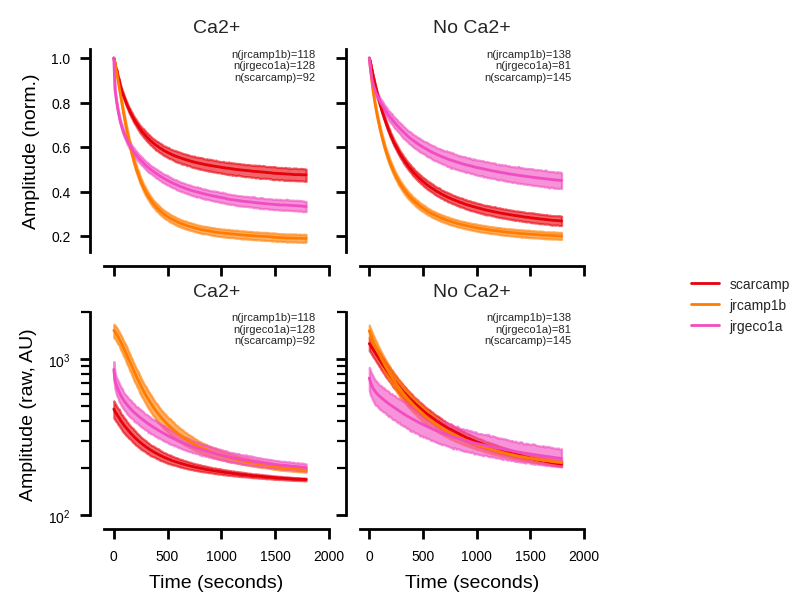

In [20]:
g = sns.relplot(
    use_df,
    x="t",
    y="value",
    col="condition",
    row="variable",
    row_order=["norm_amp", "raw_amp"],
    kind="line",
    hue="well_sanitized",
    palette=pal,
    errorbar=("ci", 95),
    err_kws={"alpha": 0.6},
    height=1.5,
    facet_kws={"sharey": "row", "sharex": True},
)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
for _ax in g.axes[1]:
    _ax.set_yscale("log")
    _ax.set_ylim([1e2, 2e3])
g.set(xlabel="Time")


def relabel_y(data, color=None):
    ax = plt.gca()
    use_label = data["variable"].iat[0]
    nrois = data.groupby("well_sanitized")["roi"].nunique()
    show_text = ""
    for _sensor, _nrois in nrois.items():
        show_text += f"n({_sensor})={_nrois}\n"
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    xrange = xlims[1] - xlims[0]
    yrange = ylims[1] - ylims[0]
    xpos = xlims[1]
    ypos = ylims[1]
    ax.text(xpos, ypos, show_text, ha="right", va="top", fontsize=4)
    if use_label == "norm_amp":
        ax.set_ylabel("Amplitude (norm.)")
    else:
        ax.set_ylabel("Amplitude (raw, AU)")


g.map_dataframe(relabel_y)
g.set_titles(template="{col_name}")
g.set(xlabel="Time (seconds)", xticks=np.arange(0, 2001, 500))
g._legend.set_title("")
sns.despine(offset=5)
g.fig.savefig(os.path.join(fig_dir, "photobleaching_1p.pdf"), dpi=600, bbox_inches="tight")

In [21]:
baseline_df = (
    use_df.query("t < 5 and variable == 'raw_amp'")
    .groupby(["well_sanitized", "condition", "roi"])["value"]
    .mean()
    .reset_index()
)

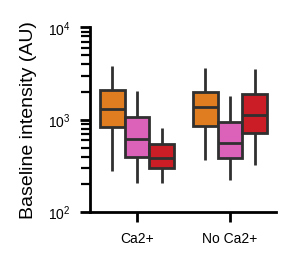

In [22]:
fig, ax = plt.subplots(1, figsize=(1.2, 1.2))
sns.boxplot(
    baseline_df,
    # alpha=0.35,
    x="condition",
    order=["Ca2+", "No Ca2+"],
    y="value",
    hue="well_sanitized",
    palette=pal,
    legend=False,
    showfliers=False,
    showcaps=False,
    # dodge=True,
)
ax.set_yscale("log")
ax.set_ylim(1e2, 1e4)
ax.set_ylabel("Baseline intensity (AU)")
ax.set_xlabel("")
sns.despine()
fig.savefig(os.path.join(fig_dir, "baseline_brightness_1p.pdf"), dpi=600, bbox_inches="tight")

In [23]:
import statsmodels.api as sm

In [24]:
def loess_slope(df, t="t", f="value", frac=0.1):

    F = df[f].to_numpy()
    t = df[t].to_numpy()
    F_norm = F / F[0]
    loess = sm.nonparametric.lowess(F_norm, t, frac=frac, return_sorted=True)
    t_smooth, F_smooth = loess[:, 0], loess[:, 1]
    dF_dt = np.gradient(F_smooth, t_smooth)
    avg_slope = np.mean(dF_dt)
    return avg_slope


use_slope = use_df.query("variable == 'norm_amp'").groupby(["well_sanitized", "condition", "roi"]).apply(loess_slope)

/tmp/conda-stage-cW3i/microscopy/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/tmp/conda-stage-cW3i/microscopy/lib/python3.10/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/tmp/conda-stage-cW3i/microscopy/lib/python3.10/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/tmp/conda-stage-cW3i/microscopy/lib/python3.10/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/tmp/conda-stage-cW3i/microscopy/lib/python3.10/site-packages/numpy/lib/function_base.py:1259: RuntimeWarning: invalid value encountered in scalar divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/tm

In [25]:
photobleaching_df = (use_slope * 60).dropna()
photobleaching_df.name = "bleach_rate_permin"
photobleaching_df = photobleaching_df.reset_index()

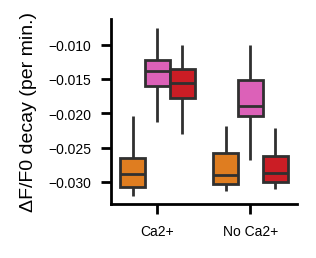

In [26]:
fig, ax = plt.subplots(1, figsize=(1.2, 1.2))
sns.boxplot(
    photobleaching_df,
    # alpha=0.35,
    x="condition",
    order=["Ca2+", "No Ca2+"],
    y="bleach_rate_permin",
    hue="well_sanitized",
    palette=pal,
    legend=False,
    showcaps=False,
    showfliers=False,
    # dodge=True,
)
ax.set_ylabel("ΔF/F0 decay (per min.)")
ax.set_xlabel("")
sns.despine()
fig.savefig(os.path.join(fig_dir, "photobleaching_rate_1p.pdf"), dpi=600, bbox_inches="tight")